<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/custom_summerizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai

In [2]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
import os
LANGCHAIN_API_KEY = userdata.get('Langchain_api_key')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"


In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash",api_key=GOOGLE_API_KEY)
llm.invoke("hi")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5bce0fd1-8148-493c-a879-b60235f30582-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [5]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph , START, END
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
MemorySaver()

In [8]:
class MessagesState(MessagesState):
  summary :str

In [86]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def Assistant(state:MessagesState) -> MessagesState:

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"this is naveed: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": response}

In [95]:
def Assistant_Secretory(state: MessagesState):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"this is naveed and this is my first msg: {summary}\n\n"
            "Extend summary above:"
        )
        messages = state["messages"] + [HumanMessage(content=summary_message)]

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    # messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [96]:
def should_continue(state: MessagesState):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "Assistant_Secretory"

    # Otherwise we can just end
    return END

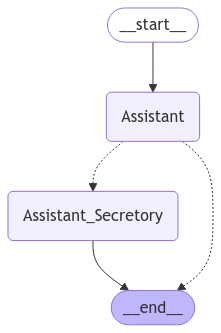

In [97]:
builder = StateGraph(MessagesState)
builder.add_node("Assistant",Assistant)
builder.add_node("Assistant_Secretory",Assistant_Secretory)
builder.add_edge(START , "Assistant")
builder.add_conditional_edges("Assistant", should_continue)
builder.add_edge("Assistant_Secretory",END)
graph: CompiledStateGraph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [98]:
config = {"configurable": {"thread_id": "1"}}

In [99]:
# Start conversation
input_message = HumanMessage(content="hi! im naveed s/o nizam uddin")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what is my father name?!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Naveed!  It's nice to meet you.  How can I help you today?


================================== Ai Message ==================================

Your name is Naveed.


================================== Ai Message ==================================

Your father's name is Nizam Uddin.


In [92]:
graph.get_state(config).values.get("summary","")

"The conversation began with a simple greeting and introduction from Naveed, who identified himself as Naveed s/o Nizam Uddin.  He then revealed he was exploring the capabilities of Generative AI, indicating an interest in learning about this technology.  The brief exchange served as an initial interaction, establishing a foundation for further discussion or exploration of Generative AI's functionalities and applications.  Naveed's proactive introduction and statement of purpose suggest a desire for information or assistance related to Generative AI. The overall tone was polite and inquisitive.\n"

In [93]:
input_message = HumanMessage(content="I like karachi, do u tell me about India?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

India is a vast and diverse country in South Asia.  It's known for its rich history, vibrant culture, and incredible variety of landscapes, from the Himalayas to the tropical beaches of the south.  

Some key features of India include:

* **Diversity:**  India is home to a multitude of languages, religions, and ethnicities.  Hinduism is the majority religion, but there are also significant populations of Muslims, Christians, Sikhs, Buddhists, and Jains, among others.  This diversity is reflected in the country's cuisine, art, music, and traditions.

* **History:**  India has a long and fascinating history, dating back thousands of years.  It's the birthplace of several major religions and has been home to powerful empires and kingdoms.  Ancient cities like Varanasi and historical monuments like the Taj Mahal are testament to this rich past.

* **Culture:**  Indian culture is incredibly rich and varied, wi

In [100]:
graph.get_state(config).values.get("summary","")

"Naveed's initial interaction, seemingly simple, reveals a sophisticated understanding of testing AI capabilities.  His methodical approach, beginning with basic personal information retrieval, establishes a baseline for memory and data processing.  The subsequent shift to geographically diverse topics (Karachi and India) demonstrates a deliberate attempt to assess the AI's ability to handle context switching and provide relevant information across varied subject areas.  This isn't just a test of factual recall; it's a probe into the AI's ability to understand and respond to nuanced queries, demonstrating an awareness of the potential for complex interactions.  The inclusion of his personal preference for Karachi adds a layer of personalization, hinting at an interest in the AI's capacity for engaging in more contextual and potentially empathetic conversations.  The overall polite and inquisitive tone suggests a user actively seeking to understand the AI's limitations and potential, mo